# architecture-28-111 ( Basic Classification ) zig-zag

## What's new:

1- Without RSI

2- add labels only start and end of trends.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import talib


In [2]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-28-111/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [21]:
# 2 - Label trend reversals using TA-Lib
def label_reversal_points(high, low, close, deviation=0.02, backstep=5):
    """
    Identify trend peaks (2) and valleys (1) similar to ZigZag logic
    using TA-Lib MINMAX + deviation filter.
    """
    n = len(close)
    labels = np.zeros(n, dtype=int)

    # Use TA-Lib MINMAX for local extrema
    max_idx = talib.MAXINDEX(high, timeperiod=backstep)
    min_idx = talib.MININDEX(low, timeperiod=backstep)

    last_pivot = None
    last_pivot_idx = None

    for i in range(backstep, n):
        if i == max_idx[i]:  # local high
            if last_pivot is None or (abs(high[i] - last_pivot) / last_pivot) > deviation:
                labels[i] = 1
                last_pivot = high[i]
                last_pivot_idx = i

        elif i == min_idx[i]:  # local low
            if last_pivot is None or (abs(low[i] - last_pivot) / last_pivot) > deviation:
                labels[i] = 2
                last_pivot = low[i]
                last_pivot_idx = i

    return labels

# Apply function
df["Label"] = label_reversal_points(
    df["HIGH"].values,
    df["LOW"].values,
    df["CLOSE"].values,
    deviation=0.01,   # how far price must move before marking a reversal
    backstep=10        # minimum candles between peaks/valleys
)

print(df[["DATE", "TIME", "CLOSE", "Label"]].tail(30))


             DATE      TIME   CLOSE  Label
55053  2024.05.01  17:00:00  26.475      0
55054  2024.05.01  18:00:00  26.527      0
55055  2024.05.01  19:00:00  26.457      0
55056  2024.05.01  20:00:00  26.442      0
55057  2024.05.01  21:00:00  26.861      1
55058  2024.05.01  22:00:00  26.535      0
55059  2024.05.01  23:00:00  26.631      0
55060  2024.05.02  01:00:00  26.699      0
55061  2024.05.02  02:00:00  26.756      0
55062  2024.05.02  03:00:00  26.763      0
55063  2024.05.02  04:00:00  26.716      0
55064  2024.05.02  05:00:00  26.629      0
55065  2024.05.02  06:00:00  26.558      0
55066  2024.05.02  07:00:00  26.554      0
55067  2024.05.02  08:00:00  26.517      2
55068  2024.05.02  09:00:00  26.538      0
55069  2024.05.02  10:00:00  26.448      0
55070  2024.05.02  11:00:00  26.405      0
55071  2024.05.02  12:00:00  26.362      0
55072  2024.05.02  13:00:00  26.225      2
55073  2024.05.02  14:00:00  26.290      0
55074  2024.05.02  15:00:00  26.080      0
55075  2024

In [24]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

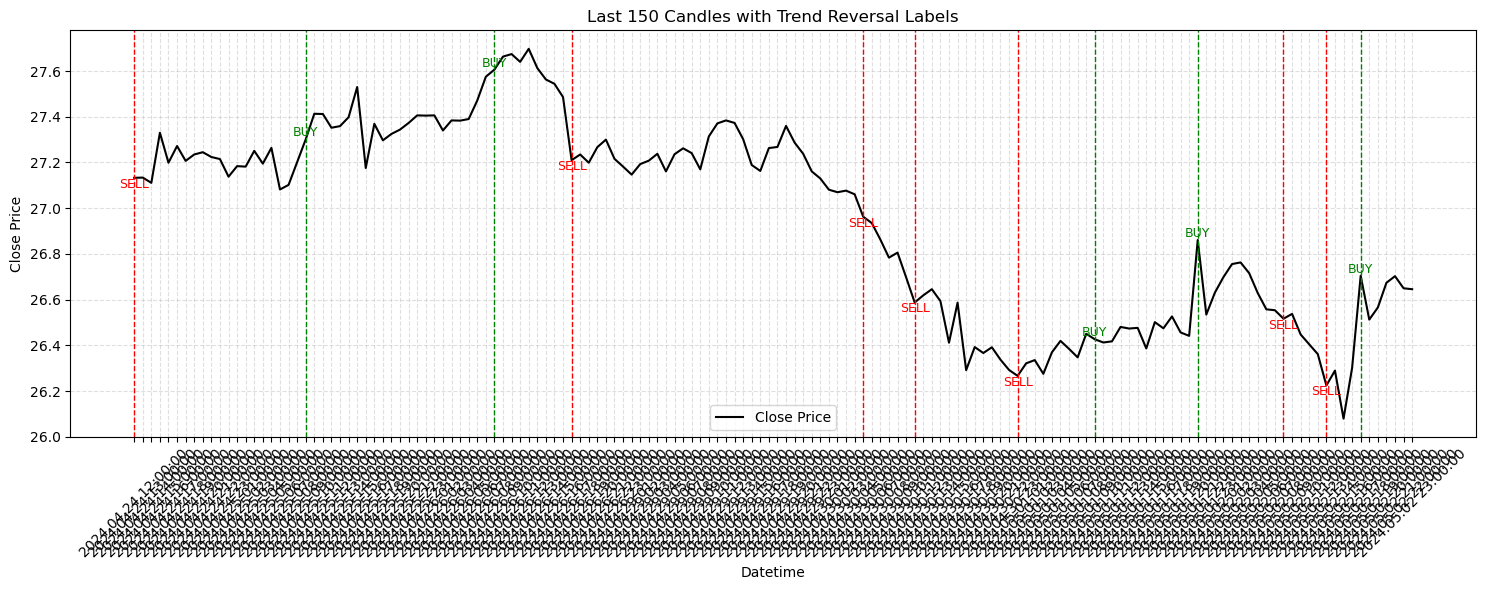

In [25]:
plot_labeled_candles(df)

# plot section